In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import InterpXY
from math import *
import numpy as np
from termodyn import DirectBallMany, get_optsmany_sample, get_dpsi_array
from powderlayer import PowderBD
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq

In [5]:
pdb = PowderBD()

In [6]:
def get_opts(*tups, **kwargs):
    powders = []
    for name, omega in tups:
        p = pdb[name]
        dpsidz, zs = get_dpsi_array(k1=p['k_1'], k2=p['k_2'], l1=p['lambda_1'], l2=p['lambda_2'], z_k=p['Z_k'], n=1000, norm_to_psi1=True)
        powders.append({
            'omega': omega,      # масса навески пороха, г
            'I_k': p['I_k'],      # импульс конца горения МПа*с
            'alpha_k': p['alpha_k'], # коволюм
            'ro': p['ro'],        # плотность пороха г/см^3   
            'f': p['f'],       # сила пороха, МДж/кг
            'etta': p['etta'],    # k -1
            'T_1': p['T_1'],    # темп. горения ?
            'zs': zs,        # точки z для интерполяции dpsi_dz
            'dpsi_dz': dpsidz# точки dpsi_dz для интерполяции dpsi_dz
        })
    opts = {
    'powders': powders,
    'init_cond': {
        'd': kwargs.get('d', 30),           # калибр, мм      
        'K_zar': kwargs.get('K_zar', 1.08),    # коэфф, учитывающий доп работы
        'q': kwargs.get('q', 400),         # масса снаряда, г
        'W_kam': kwargs.get('W_kam', 120),   # объем каморы, см^3
        'sigma_T': kwargs.get('sigma_T', 376),   # Постоянная коэффициента теплоотдачи, Дж*м/кг*К*с
        'T_stenki': kwargs.get('T_stenki', 293),  # Температура стенки, К
        'p_f': kwargs.get('p_f', 50e6),      # Давление форсирования, Па

        'p0': kwargs.get('p0', 5e6),        # Давление вспышки, Па
        'k_vospl': kwargs.get('k_vospl', 1.22),  # Коэффициент адиабаты газов воспламенителя
        'f_vospl': kwargs.get('f_vospl',0.26),  # Cила воспламенителя, МДж/кг
        'T_vospl': kwargs.get('T_vospl', 2427)   # Температура газов воспламенителя, К
    },
    'integr_cond': {
        'l_max': kwargs.get('l_max', 2.400),   # длина ствола
        't_max': kwargs.get('t_max', 0.5),     # на всякий пожарынй
        'dt': kwargs.get('dt', 6e-6)        # шаг по времени
    }
    }
    return opts

In [7]:
def exper(q, om, p_m_exper, pd_exper, v_d_exper, message, p_f=80e6,  printly=True):
    opts = get_opts(('6\\7 гр', om), q=q, p_f=p_f)
    ball = DirectBallMany(opts)
    res = ball.run()
    p_max = np.max(res[:,1])/1e5
    xd = res[-1,2] - 0.154
    i = np.argwhere(res[:,2]>res[-1,2] - 0.154)[0][0]
    
    p_d = res[i,1]/1e5 / ball.fi/2
    v_d = res[-1,4]
    perr = (p_max-p_m_exper)/p_m_exper*100
    pderr = (p_d-pd_exper)/pd_exper*100
    vderr = (v_d-v_d_exper)/v_d_exper*100
    if printly:
        print(f'{message:15}:  p={perr:7.2f}%, pd ={pderr:7.2f}%, v = {vderr:7.2f}%')
    return (perr, pderr, vderr)

exper(402.2, 120, 4750, 255, 968, 'полный')
exper(402.2, 60, 1760, 123, 655, 'ползаряда')
exper(228.8, 120, 2750, 400, 1140, 'легкий')


полный         :  p=  -3.14%, pd = -26.52%, v =    4.72%
ползаряда      :  p= -29.59%, pd = -48.07%, v =  -18.34%
легкий         :  p=  -1.46%, pd = -67.86%, v =  -10.98%


(-1.4609365726053345, -67.85947456595716, -10.984304736019665)

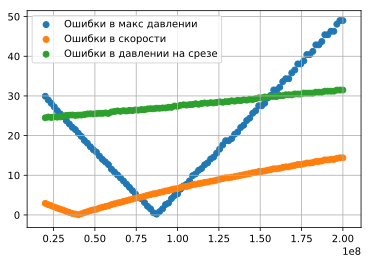

In [8]:
pfs = np.linspace(20,200,100)*1e6
perrs = []
verrs = []
pderrs = []
for pf in tqdm_notebook(pfs):
    p1, pd1, vd1 = exper(402.2, 120, 4750, 255, 968, 'полный', p_f=pf, printly=False)
    p2, pd2, vd2 = exper(402.2, 60, 1760, 123, 655, 'ползаряда', p_f=pf,printly= False)
    p3, pd3, vd3 = exper(228.8, 120, 2750, 400, 1140, 'легкий', p_f=pf,printly= False)
    ps = np.array([p1])
    perrs.append(abs(ps[np.argmax(np.abs(ps))]))
    vs = np.array([vd1])
    verrs.append(abs(vs[np.argmax(np.abs(vs))]))
    pds = np.array([pd1])
    pderrs.append(abs(pds[np.argmax(np.abs(pds))]))
plt.scatter(pfs, perrs, label='Ошибки в макс давлении')
plt.scatter(pfs, verrs, label='Ошибки в скорости')
plt.scatter(pfs, pderrs, label='Ошибки в давлении на срезе')
plt.grid()
plt.legend()
plt.show()

In [50]:
pdb.all_powders_dict.keys()

dict_keys(['СФ 033', 'ВУ фл', 'ВТ', 'ВТМ', 'ВТХ-10', 'ВТХ-20', 'ВТД-25', '4\\1', '4\\1 фл', '4\\7', '4\\7 св', '4\\7 фл ВБП', '4\\7 ПТ-3 фл', '4\\7 Ц гр', '5\\1', '5\\1 х-10', '5\\1 х-20', '5\\1 д-20', '5\\1 д-25', '5\\7 св', '5\\7 н\\а', '5\\7 в\\а', '5\\7 Ц фл', '6\\7 гр', '6\\7 БП гр', '6\\7 фл В БП', '6\\7 П-5 БП фл', '6\\7 фл ', '7\\1', '7\\1 фл БП', '7\\7', '7\\14', '7\\1 УГ', '8\\1 тр', '8\\7', '8\\1 УГ', '9\\7', '9\\7 МН', '9\\7 БП', '11\\1 БП', '11\\7', '11\\1 УГ', '12\\1 Тр', '12\\1 тр БП', '12\\1 тр МН', '12\\7', '12\\7 В\\А', '12\\1 УГ', '14\\1 тр В\\А', '14\\7', '14\\7 В\\А', '14\\7 БП', '15\\1 тр В\\А', '15\\7', '16\\1 тр', '16\\1 тр В\\А', '17\\7', '18\\1 тр', '18\\1 тр БП', '22\\1 тр', '22\\7', '23\\7', '28\\1 тр', '37\\1 тр', 'НДТ-3 16\\1', 'НДТ-3 18\\1', 'НДТ-3 19\\1', 'НДТ-3 23\\1', 'НДТ-3 32\\1', 'НДТ-3 152\\57', 'ДГ-2 15\\1', 'ДГ-2 17\\1', 'ДГ-3 13\\1', 'ДГ-3 14\\1', 'ДГ-3 17\\1', 'ДГ-3 18\\1', 'ДГ-3 20\\1', 'ДГ-3 23\\1', 'ДГ-4 13\\1', '100\\56', '100\\70', '130\\5

In [72]:
a = np.linspace(-1,2,10)
a[a>1][0]
np.argwhere(a>1)[0][0]

7

In [10]:
def exper2(q, om, p_m_exper, pd_exper, v_d_exper, message, p_f=80e6,  printly=True):
    opts = get_opts(('6\\7 гр', om), q=q, p_f=p_f)
    ball = DirectBallMany(opts)
    return ball.run()

res = exper2(402.2, 120, 4750, 255, 968, 'полный', p_f=pf, printly=False)   

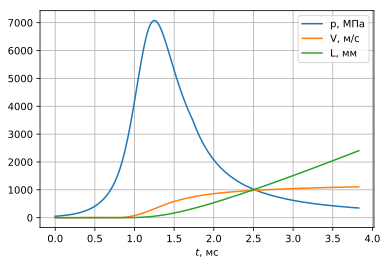

In [20]:
plt.plot(res[:, 0]*1000, res[:, 1]/1e5, label='p, МПа')
plt.plot(res[:, 0]*1000, res[:, 4], label='V, м/с')
plt.plot(res[:, 0]*1000, res[:, 2]*1000, label='L, мм')
plt.grid()
plt.xlabel('$t$, мс')
plt.legend()
plt.savefig('ozvb.png', format='png', dpi=300)

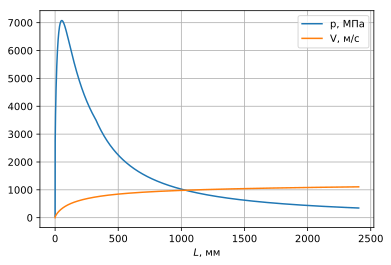

In [21]:
plt.plot(res[:, 2]*1000, res[:, 1]/1e5, label='p, МПа')
plt.plot(res[:, 2]*1000, res[:, 4], label='V, м/с')
plt.grid()
plt.xlabel('$L$, мм')
plt.legend()
plt.savefig('ozvb2.png', format='png', dpi=300)